In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import statsmodels.api as sm

import os

C:\Program Files\Anaconda3\envs\carmi_thesis_3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import importlib
import plot, loaders
plot = importlib.reload(plot)
loaders = importlib.reload(loaders)

In [3]:
PGS_DIR = os.path.join("data", "pgs")
SAVE_FIG_DIR = "figure3"

# Gain Distribution

## Longevity Height Model

In [4]:
longevity_data = loaders.load_longevity_data(pgs_col=os.path.join(PGS_DIR, "longevity_height"), convert_to_cm=True)
longevity_data.head()

const  Gender  Age       PGS  Height
FID IID                                      
2   427    1.0       0   61  0.000028  157.48
    448    1.0       1   62  0.000028  177.80
11  615    1.0       0   64  0.000042  157.48
    616    1.0       1   65  0.000086  172.72
24  887    1.0       1   65  0.000106  187.96

In [5]:
height_model_covar = sm.OLS(endog=longevity_data["Height"], exog=longevity_data[["const", "Gender", "Age"]]).fit()
print(height_model_covar.rsquared)
height_model_pgs_res = sm.OLS(endog=height_model_covar.resid, exog=longevity_data[["const", "PGS"]]).fit()
print(height_model_pgs_res.summary())

0.6083835435619124
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     65.49
Date:                Thu, 15 Aug 2019   Prob (F-statistic):           5.18e-14
Time:                        13:54:17   Log-Likelihood:                -635.79
No. Observations:                 206   AIC:                             1276.
Df Residuals:                     204   BIC:                             1282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6249      0.788 

## ASPIS IQ Model

In [6]:
aspis_data = loaders.load_aspis_data(pgs_col=os.path.join(PGS_DIR, "aspis_gcf"))
aspis_data.head()

const       PGS         IQ
FID IID                            
5   5      1.0  0.000005  95.673167
10  10     1.0 -0.000014  98.480256
11  11     1.0 -0.000012  91.335666
22  22     1.0 -0.000005  87.262629
41  41     1.0 -0.000008  97.917961

In [7]:
iq_model_pgs = sm.OLS(endog=aspis_data["IQ"], exog=aspis_data[["const", "PGS"]]).fit()
print(iq_model_pgs.summary())

                            OLS Regression Results                            
Dep. Variable:                     IQ   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     41.66
Date:                Thu, 15 Aug 2019   Prob (F-statistic):           1.76e-10
Time:                        13:54:18   Log-Likelihood:                -3770.8
No. Observations:                 919   AIC:                             7546.
Df Residuals:                     917   BIC:                             7555.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.3033      0.824    126.628      0.0

## Prediction

In [8]:
longevity_so_random_10_height_pgs = loaders.load_pgs(os.path.join(PGS_DIR, "longevity_so_random_10_height"))
longevity_so_random_10_height_pred = height_model_pgs_res.predict(sm.add_constant(longevity_so_random_10_height_pgs))
longevity_so_random_10_height_pred.head()

FID        IID 
1130_2269  SO00   -0.549753
           SO01   -1.091629
           SO02   -0.191868
           SO03   -0.783496
           SO04   -0.474859
dtype: float64

In [9]:
longevity_so_actual_10_height_pgs = loaders.load_pgs(os.path.join(PGS_DIR, "longevity_so_actual_10_height"))
longevity_so_actual_10_height_pred = height_model_pgs_res.predict(sm.add_constant(longevity_so_actual_10_height_pgs))
longevity_so_actual_10_height_pgs.head()

FID        IID 
1130_1131  SO00    0.000031
           SO01   -0.000007
           SO02    0.000014
           SO03    0.000018
           SO04    0.000002
Name: PGS, dtype: float64

In [10]:
aspis_so_random_10_gcf_pgs = loaders.load_pgs(os.path.join(PGS_DIR, "aspis_so_random_10_gcf"))
aspis_so_random_10_iq_pred = iq_model_pgs.predict(sm.add_constant(aspis_so_random_10_gcf_pgs))
aspis_so_random_10_iq_pred.head()

FID        IID 
1002_3186  SO00    96.097116
           SO01    94.172263
           SO02    94.364762
           SO03    91.499255
           SO04    98.227435
dtype: float64

In [11]:
preds = pd.concat({"longevity_random": longevity_so_random_10_height_pred,
                   "longevity_actual": longevity_so_actual_10_height_pred,
                   "aspis_random": aspis_so_random_10_iq_pred},
                  names=["set"], axis="index")
preds.sample(n=6)

set               FID        IID 
aspis_random      6341_297   SO05    102.205711
longevity_random  6223_6018  SO04     -0.087693
                  2111_1235  SO02     -0.071881
aspis_random      1206_6426  SO08     99.201862
longevity_random  4136_6505  SO04      2.333522
aspis_random      2084_2352  SO03     99.672099
dtype: float64

## Analyze

In [12]:
gain = preds.groupby(["set", "FID"]).agg(["max", "mean"])
gain = gain["max"] - gain["mean"]
gain.sample(n=6)

set               FID      
aspis_random      3041_7369    5.883466
                  2150_1031    5.164896
longevity_actual  6614_6615    1.794749
longevity_random  3197_5033    2.626409
                  5053_7151    2.021629
                  2001_2203    2.366013
dtype: float64

In [13]:
gain.groupby(["set"]).describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).T

set    aspis_random  longevity_actual  longevity_random
count    500.000000        102.000000        498.000000
mean       3.206439          3.042820          3.052385
std        1.061268          0.976256          1.029207
min        0.849277          1.108058          0.736057
10%        2.031640          1.936839          1.869860
25%        2.433799          2.302554          2.338265
50%        3.017769          3.014225          2.846158
75%        3.835814          3.603939          3.796806
90%        4.687937          4.355261          4.416856
max        7.627895          5.660902          6.418799

In [17]:
gain.groupby(["set"]).std()

set
aspis_random        1.061268
longevity_actual    0.976256
longevity_random    1.029207
dtype: float64

### GAIN PDF

In [14]:
PLOT_THICKENS = True
if PLOT_THICKENS:
    # sns.plotting_context("talk")
    CUSTOM_SNS_RC = {'xtick.labelsize': 13.5, 'ytick.labelsize': 13.5, 'legend.fontsize': 13.0, 
                                                 'axes.labelsize': 14, 'axes.titlesize': 15}
    # sns.set_context("paper", font_scale=1.4, rc=CUSTOM_SNS_RC)
    sns.set_context("talk", font_scale=1, rc=CUSTOM_SNS_RC)

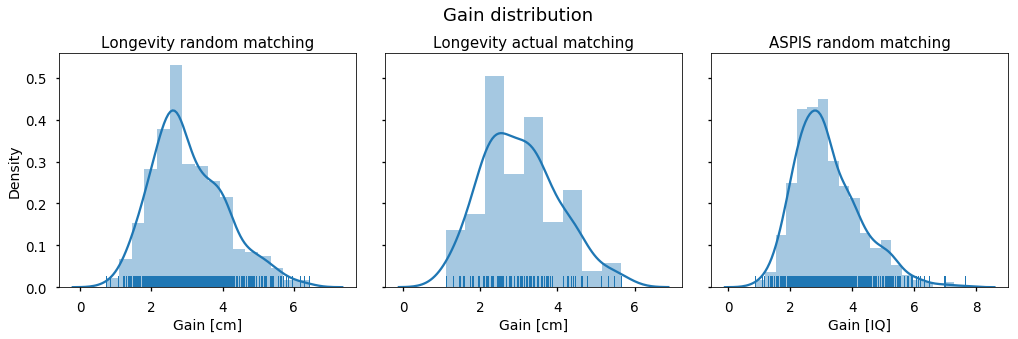

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(17, 4.3), sharey=True)

sns.distplot(a=gain.xs("longevity_random"), 
             hist=True, kde=True, rug=True, norm_hist=True,
             label=None, axlabel="Gain [cm]", ax=ax[0])
sns.distplot(a=gain.xs("longevity_actual"), 
             hist=True, kde=True, rug=True, norm_hist=True,
             label=None, axlabel="Gain [cm]", ax=ax[1])
sns.distplot(a=gain.xs("aspis_random"), 
             hist=True, kde=True, rug=True, norm_hist=True,
             label=None, axlabel="Gain [IQ]", ax=ax[2])

ax[0].set_title("Longevity random matching")
ax[1].set_title("Longevity actual matching")
ax[2].set_title("ASPIS random matching")
ax[0].set_ylabel("Density")
fig.subplots_adjust(wspace=0.1)
if PLOT_THICKENS:
    fig.suptitle("Gain distribution", y=1.032, fontsize=18)
else:
    fig.suptitle("Gain distribution", y=1.0, fontsize=14)

In [16]:
plot.save_fig(fig, "gain_pdf" + ("_thick" if PLOT_THICKENS else ""), SAVE_FIG_DIR)

### Gain CDF

In [17]:
gain = preds.groupby(["set", "FID"]).agg(["max", "mean"])

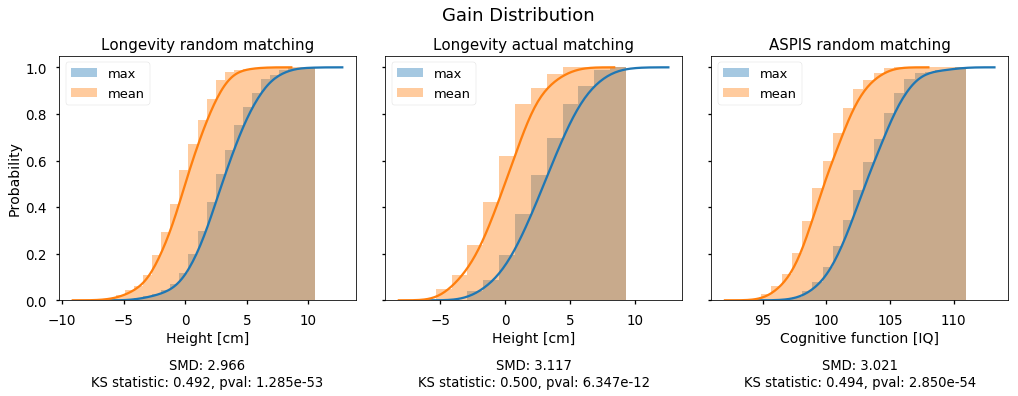

In [18]:
ecdf = False
mutual_bins = True
annotate_dist = 0.3 if PLOT_THICKENS else 0.2
fig, ax = plt.subplots(1, 3, figsize=(17, 4.5), sharey=True)

plot.display_distribution_differences(x=gain.xs("longevity_random")["max"],
                                      y=gain.xs("longevity_random")["mean"], 
                                      ecdf=ecdf, mutual_bins=mutual_bins, xlabel="Height [cm]", ax=ax[0],
                                      annotate_dist=annotate_dist)
plot.display_distribution_differences(x=gain.xs("longevity_actual")["max"],
                                      y=gain.xs("longevity_actual")["mean"], 
                                      ecdf=ecdf, mutual_bins=mutual_bins, xlabel="Height [cm]", ax=ax[1],
                                      annotate_dist=annotate_dist)
plot.display_distribution_differences(x=gain.xs("aspis_random")["max"],
                                      y=gain.xs("aspis_random")["mean"], 
                                      ecdf=ecdf, mutual_bins=mutual_bins, xlabel="Cognitive function [IQ]", ax=ax[2],
                                      annotate_dist=annotate_dist)

ax[0].set_title("Longevity random matching")
ax[1].set_title("Longevity actual matching")
ax[2].set_title("ASPIS random matching")
ax[0].set_ylabel("Probability")
fig.subplots_adjust(wspace=0.1)
if PLOT_THICKENS:
    [ax[i].texts[0].set_fontsize(13.2) for i in range(3)]  # decrease annotation font size
    fig.suptitle("Gain Distribution", y=1.032, fontsize=18)
else:
    fig.suptitle("Gain Distribution", y=1.0, fontsize=14)

In [19]:
plot.save_fig(fig, "gain_max-min_cdf" + ("_thick" if PLOT_THICKENS else ""), SAVE_FIG_DIR)

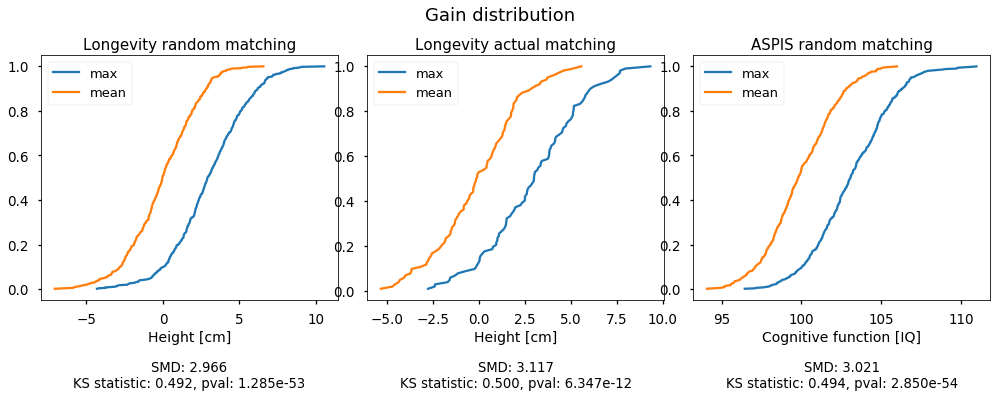

In [20]:
ecdf = True
mutual_bins = True
annotate_dist = 0.31 if PLOT_THICKENS else 0.2
fig, ax = plt.subplots(1, 3, figsize=(17, 4.5))

plot.display_distribution_differences(x=gain.xs("longevity_random")["max"],
                                      y=gain.xs("longevity_random")["mean"], 
                                      ecdf=ecdf, mutual_bins=mutual_bins, xlabel="Height [cm]", ax=ax[0],
                                      annotate_dist=annotate_dist)
plot.display_distribution_differences(x=gain.xs("longevity_actual")["max"],
                                      y=gain.xs("longevity_actual")["mean"], 
                                      ecdf=ecdf, mutual_bins=mutual_bins, xlabel="Height [cm]", ax=ax[1],
                                      annotate_dist=annotate_dist)
plot.display_distribution_differences(x=gain.xs("aspis_random")["max"],
                                      y=gain.xs("aspis_random")["mean"], 
                                      ecdf=ecdf, mutual_bins=mutual_bins, xlabel="Cognitive function [IQ]", ax=ax[2],
                                      annotate_dist=annotate_dist)

ax[0].set_title("Longevity random matching")
ax[1].set_title("Longevity actual matching")
ax[2].set_title("ASPIS random matching")
fig.subplots_adjust(wspace=0.1)
if PLOT_THICKENS:
    [ax[i].texts[0].set_fontsize(13.2) for i in range(3)]  # decrease annotation font size
    fig.suptitle("Gain distribution", y=1.03, fontsize=18)
else:
    fig.suptitle("Gain distribution", y=1.0, fontsize=14)

In [21]:
plot.save_fig(fig, "gain_max-min_ecdf" + ("_thick" if PLOT_THICKENS else ""), SAVE_FIG_DIR)